In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az
import warnings

%matplotlib inline

In [2]:
warnings.filterwarnings("ignore")

## Question 5

For the model in Question 1,

$$
\begin{align*}
y_{i}  &\sim Normal(\mu, \sigma)
\\
\mu &\sim Normal(0, 10)
\\
\sigma &\sim \left | Normal(0, 25) \right |
\end{align*}
$$

assume that you have a dataset of 57 data points coming from a Gaussian of mean 4 and standard deviation 0.5. Using PyMC3, compute:
1. Posterior distribution
2. Prior distribution
3. Posterior Predictive distribution
4. Prior Predictive distribution

In [3]:
data = np.random.normal(4, 0.5, 57)
data.shape

(57,)

In [4]:
BoundedNormal = pm.Bound(pm.Normal, 0, 1)

with pm.Model() as model_q1:
    mu = pm.Normal("mu", mu=0, sd=10)
    sig = BoundedNormal("sig", mu=0, sd=25)
    
    y = pm.Normal("y", mu=mu, sd=sig, observed=data)
    
    trace_q1 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:10<00:00, 2363.00draws/s]


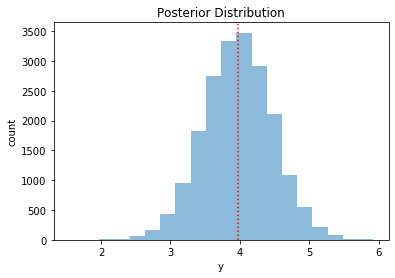

In [5]:
post = [np.random.normal(mu, sig, 1)[0] for mu, sig in zip(trace_q1["mu"], trace_q1["sig"])]
post_mean = np.mean(post)

plt.hist(post, bins=20, alpha=0.5)
plt.axvline(x=post_mean, color="r", linestyle="dotted", linewidth="1.5")
plt.xlabel("y")
plt.ylabel("count")
plt.title("Posterior Distribution")
_ = plt.show()

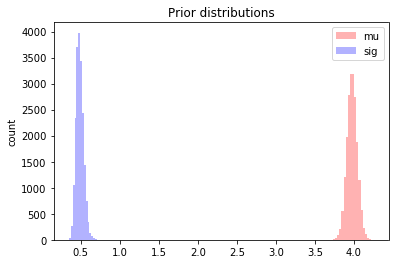

In [6]:
prior_mu = trace_q1["mu"]
prior_sig = trace_q1["sig"]
plt.hist(prior_mu, bins=20, color="r", alpha=0.3, label="mu")
plt.hist(prior_sig, bins=20, color="b", alpha=0.3, label="sig")
plt.ylabel("count")
plt.title("Prior distributions")
plt.legend(loc="best")
_ = plt.show()

100%|██████████| 500/500 [00:00<00:00, 1192.25it/s]


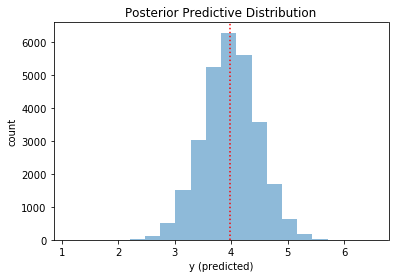

In [7]:
ppc_q1 = pm.sample_posterior_predictive(trace_q1, samples=500, model=model_q1)

ppc = ppc_q1["y"].reshape(-1, 1)
ppc_mean = np.mean(ppc)

plt.hist(ppc, bins=20, alpha=0.5)
plt.axvline(x=ppc_mean, color="r", linestyle="dotted", linewidth=1.5)
plt.xlabel("y (predicted)")
plt.ylabel("count")
plt.title("Posterior Predictive Distribution")
_ = plt.show()

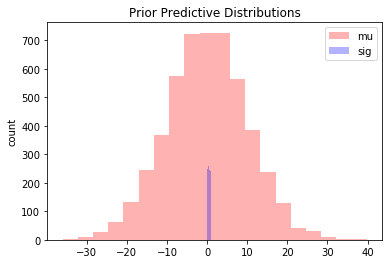

In [8]:
prior_preds_q1 = pm.sample_prior_predictive(samples=5000, model=model_q1)
prior_preds_mu = prior_preds_q1["mu"]
prior_preds_sig = prior_preds_q1["sig"]

plt.hist(prior_preds_mu, bins=20, color="r", alpha=0.3, label="mu")
plt.hist(prior_preds_sig, bins=20, color="b", alpha=0.3, label="sig")
plt.ylabel("count")
plt.title("Prior Predictive Distributions")
plt.legend(loc="best")
_ = plt.show()

## Question 6

Execute `model_g` using the default NUTS sampler and then using Metropolis. Compare the results using Arviz functions like `plot_trace` and `plot_pair`. Center the variable and repeat the experiment. What conclusions can you draw from this?

<p><font color="blue">In both cases, the Metropolis sampler ends up having greater divergence than NUTS. However, with centering, the divergence in Metropolis is less compared to without.</font></p>

In [9]:
np.random.seed(1)

N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x
y = y_real + eps_real

In [10]:
with pm.Model() as model_g1:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    μ = pm.Deterministic('μ', α + β * x)
    
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    
    trace_g1 = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:21<00:00, 545.47draws/s]
The acceptance probability does not match the target. It is 0.900456476848546, but should be close to 0.8. Try to increase the number of tuning steps.


In [11]:
with pm.Model() as model_g2:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    μ = pm.Deterministic('μ', α + β * x)
    
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    
    step = pm.Metropolis()
    trace_g2 = pm.sample(2000, tune=1000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [ϵ]
>Metropolis: [β]
>Metropolis: [α]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:05<00:00, 2266.96draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


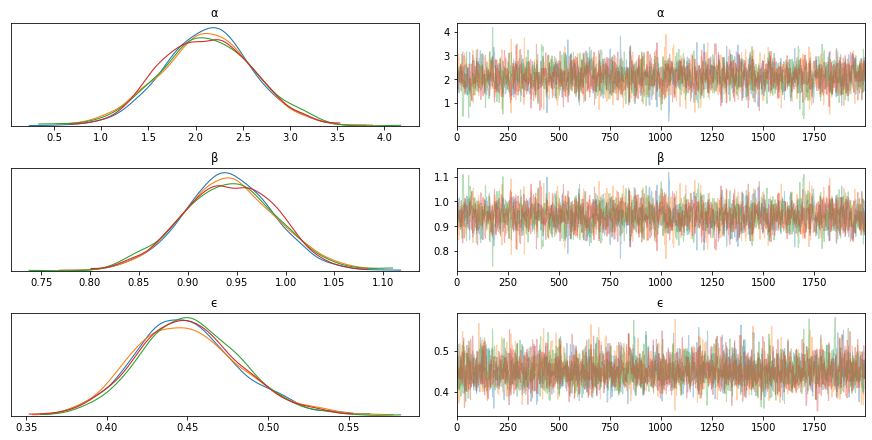

In [12]:
_ = az.plot_trace(trace_g1, var_names=['α', 'β', 'ϵ'])

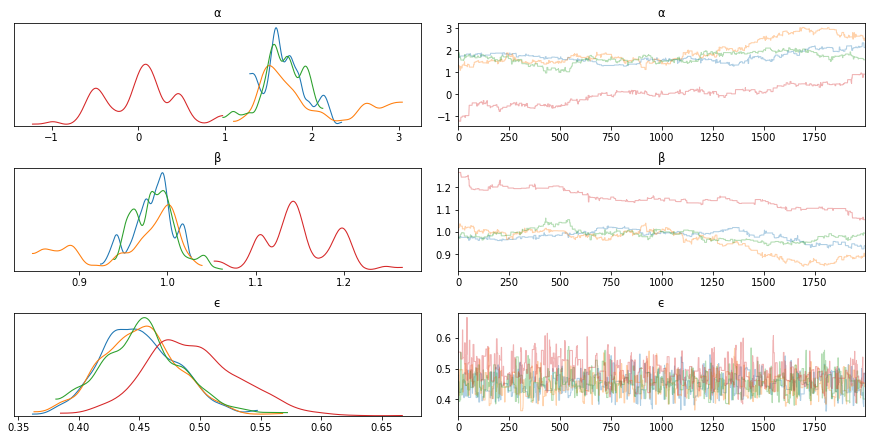

In [13]:
_ = az.plot_trace(trace_g2, var_names=['α', 'β', 'ϵ'])

In [14]:
y = y_real + eps_real
y_mean = np.mean(y)
y_ctr = y - y_mean

In [15]:
with pm.Model() as model_g3:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    μ = pm.Deterministic('μ', α + β * x)
    
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_ctr)
    
    trace_g3 = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:19<00:00, 606.53draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [16]:
with pm.Model() as model_g4:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    μ = pm.Deterministic('μ', α + β * x)
    
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_ctr)
    
    step = pm.Metropolis()
    trace_g4 = pm.sample(2000, tune=1000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [ϵ]
>Metropolis: [β]
>Metropolis: [α]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:05<00:00, 2274.56draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


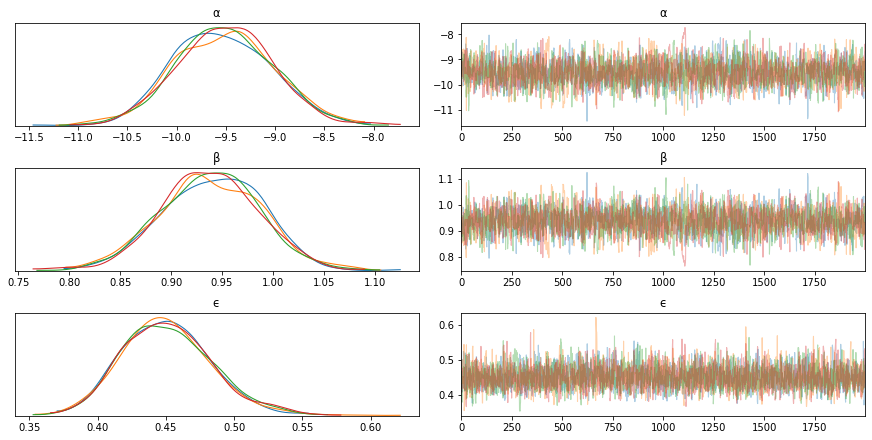

In [17]:
_ = az.plot_trace(trace_g3, var_names=['α', 'β', 'ϵ'])

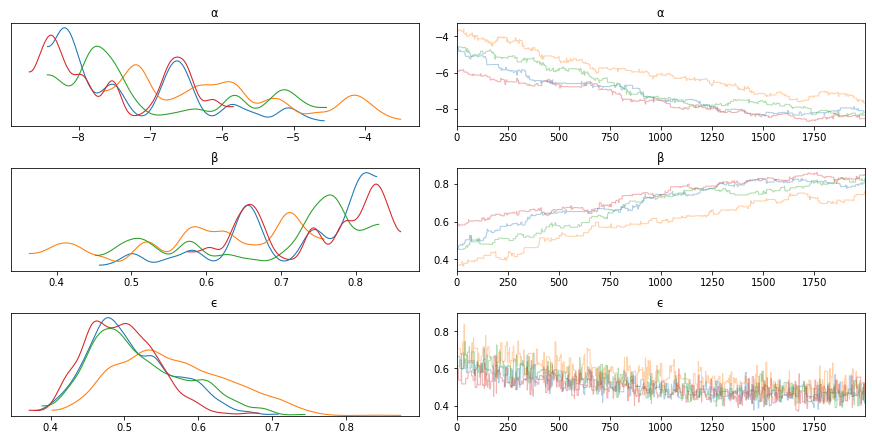

In [18]:
_ = az.plot_trace(trace_g4, var_names=['α', 'β', 'ϵ'])

## Question 7

Using the howell dataset (available at https://github.com/aloctavodia/BAP) to create a linear model of the weight (x) against the height (y). Exclude subjects that are younger than 18. Explain the results.

<p><font color="blue">Linear Model predicts the height of the over-18 population as the sum of a baseline height (109 cms) plus 0.996 cm for every kilogram of weight.</font></p>

In [19]:
howell_df = pd.read_csv("../BAP/code/data/howell.csv", delimiter=";")
howell_df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [20]:
data = howell_df[howell_df["age"] > 18][["weight", "height"]].values
x, y = data[:, 0], data[:, 1]

with pm.Model() as model_q7:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_q7 = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:15<00:00, 757.56draws/s] 
The acceptance probability does not match the target. It is 0.8908471455983661, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8983413657475477, but should be close to 0.8. Try to increase the number of tuning steps.


In [21]:
az.summary(trace_q7, var_names=['α', 'β'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,109.695,2.047,105.916,113.639,0.041,0.029,2516.0,2513.0,2520.0,2643.0,1.0
β,0.996,0.045,0.911,1.080,0.001,0.001,2552.0,2552.0,2555.0,2692.0,1.0


100%|██████████| 100/100 [00:00<00:00, 703.01it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


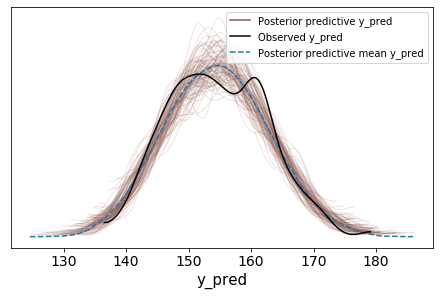

In [22]:
ypred_q7 = pm.sample_posterior_predictive(trace_q7, 100, model_q7)
ppc_q7 = az.from_pymc3(trace=trace_q7, posterior_predictive=ypred_q7)
az.plot_ppc(ppc_q7)
_ = plt.legend(loc="best")

## Question 8

For four subjects, we get the weights (45.73, 65.8, 54.2, 32.59), but not their heights. Using the model from the previous exercise, predict the height for each subject, together with their HPDs of 50% and 94%.

- Tip1: Check coal mining disaster example in the PyMC3 documentation.
- Tip2: Use shared variables

In [23]:
weights = [45.73, 65.8, 54.2, 32.59]
heights = [(109.695 + 0.996 * x) for x in weights]
heights

[155.24208, 175.2318, 163.6782, 142.15464]

In [24]:
with pm.Model() as model_q8:
    x_shared = pm.Data("x", x)
    y_shared = pm.Data("y", y)
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = pm.Deterministic('μ', α + β * x_shared)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_shared)
    trace_q8 = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:15<00:00, 760.67draws/s] 


In [25]:
with model_q8:
    pm.set_data({"x": weights})
    ppc_q8 = pm.sample_posterior_predictive(trace_q8, samples=500)

100%|██████████| 500/500 [00:04<00:00, 106.81it/s]


In [26]:
for i in range(len(weights)):
    predicted_heights = ppc_q8["y_pred"][:, i]
    print("weight: {:.3f} => height (mean: {:.3f}, std.dev: {:.3f})".format(
        weights[i], np.mean(predicted_heights), np.std(predicted_heights)))

weight: 45.730 => height (mean: 155.780, std.dev: 5.198)
weight: 65.800 => height (mean: 174.767, std.dev: 5.061)
weight: 54.200 => height (mean: 163.628, std.dev: 5.127)
weight: 32.590 => height (mean: 142.246, std.dev: 5.304)


## Question 9

Repeat exercise 7, this time including those below 18 years old. Explain the results.

<font color="blue">
<p>Linear model predicts height as a baseline height of 74.672 cm and an increase of 1.782 cm for every kilogram of weight.</p> 
<p>Difference from previous is a lower baseline height to account for populations younger than 18, but a faster growth rate per added kilogram of weight to account for the variability in height across the entire population. In addition, the fit for taller people is not as good as the previous model where we only considered people over 18. This is another consequence of the variability in heights across the entire population as opposed to the adult population.</p>
</font>

In [27]:
data = howell_df[["weight", "height"]].values
x, y = data[:, 0], data[:, 1]

with pm.Model() as model_q9:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_q9 = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:11<00:00, 1068.70draws/s]


In [28]:
az.summary(trace_q9, var_names=['α', 'β'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,74.599,1.095,72.564,76.616,0.021,0.015,2632.0,2632.0,2638.0,2740.0,1.0
β,1.784,0.029,1.730,1.837,0.001,0.000,2704.0,2703.0,2713.0,3082.0,1.0


100%|██████████| 100/100 [00:00<00:00, 738.57it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


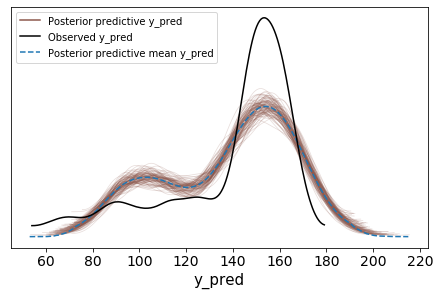

In [29]:
ypred_q9 = pm.sample_posterior_predictive(trace_q9, 100, model_q9)
ppc_q9 = az.from_pymc3(trace=trace_q9, posterior_predictive=ypred_q9)
az.plot_ppc(ppc_q9)
_ = plt.legend(loc="best")

## Question 10

It is known for many species that the weight does not scale with the height, but with the logarithm of the weight. Use this information to fit the howell data (including subjects from all ages). Do one more model, this time without using the logarithm but instead a second order polynomial. Compare and explain both results.

<font color="blue">
<p>Of the three models on the entire population in the Howell dataset, the polynomial (degree 2) model has the best fit to actual data, followed by the logarithmic model, followed by the linear model.</p>
</font>

In [30]:
with pm.Model() as model_q10a:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = pm.Deterministic('μ', α + β * pm.math.log(x))
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_q10a = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:14<00:00, 831.18draws/s] 
The number of effective samples is smaller than 25% for some parameters.


100%|██████████| 100/100 [00:00<00:00, 641.06it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


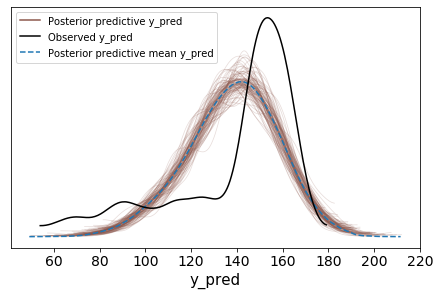

In [31]:
ypred_q10a = pm.sample_posterior_predictive(trace_q10a, 100, model_q10a)
ppc_q10a = az.from_pymc3(trace=trace_q10a, posterior_predictive=ypred_q10a)
az.plot_ppc(ppc_q10a)
_ = plt.legend(loc="best")

In [32]:
with pm.Model() as model_q10b:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = pm.Deterministic('μ', α + β[0] * x + β[1] * (x ** 2))
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_q10b = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:33<00:00, 362.57draws/s]
The acceptance probability does not match the target. It is 0.8906454065927917, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9142907321538906, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9027968445192837, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9272117506425563, but should be close to 0.8. Try to increase the number of tuning steps.


100%|██████████| 100/100 [00:00<00:00, 689.55it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


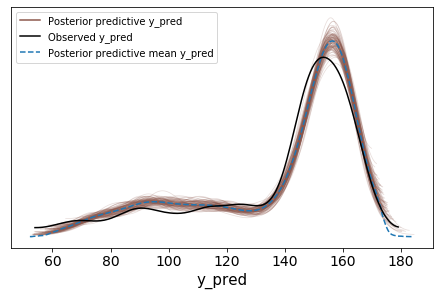

In [33]:
ypred_q10b = pm.sample_posterior_predictive(trace_q10b, 100, model_q10b)
ppc_q10b = az.from_pymc3(trace=trace_q10b, posterior_predictive=ypred_q10b)
az.plot_ppc(ppc_q10b)
_ = plt.legend(loc="best")

## Question 12

See in the accompanying code the `model_t` (and the data associated with it). Experiment with priors for $\nu$, like the non-shifted exponential and gamma priors (they are commented in the code). Plot the prior distribution to ensure that you understand them. An easy way to do this is to just comment the likelihood in the model and check the trace plot. A more efficient way is to use the `pm.sample_prior_predictive()` function instead of `pm.sample()`.

<font color="blue">
<p>Priors are approximately the same shape in all 3 cases, but the quality of posterior fit (predicted vs actual) is very different with the offset case (the one shown in the book). The other two approaches yield similar results with respect to posterior fit.</p>
</font>

In [34]:
anscombe_df = pd.read_csv("../BAP/code/data/anscombe.csv")
anscombe_df.head()

,group,x,y
0,I,10.0,8.04
1,I,8.0,6.95
2,I,13.0,7.58
3,I,9.0,8.81
4,I,11.0,8.33


In [35]:
data = anscombe_df[anscombe_df["group"]=='III'][["x", "y"]].values
x, y = data[:, 0], data[:, 1]
x.shape, y.shape

((11,), (11,))

In [36]:
with pm.Model() as model_q12a:
    α = pm.Normal('α', mu=y.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1)
    y_pred = pm.StudentT('y_pred', mu=α + β * x, sd=ϵ, nu=ν, observed=y)
    trace_q12a = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_, ϵ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:17<00:00, 556.73draws/s]
The number of effective samples is smaller than 25% for some parameters.


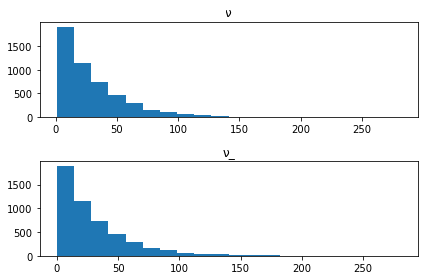

In [37]:
priors = pm.sample_prior_predictive(samples=5000, model=model_q12a)
nu = priors["ν"]
nu_ = priors["ν_"]

plt.subplot(211)
plt.hist(nu, bins=20)
plt.title("ν")

plt.subplot(212)
plt.hist(nu_, bins=20)
plt.title("ν_")

plt.tight_layout()
_ = plt.show()

100%|██████████| 100/100 [00:00<00:00, 727.09it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


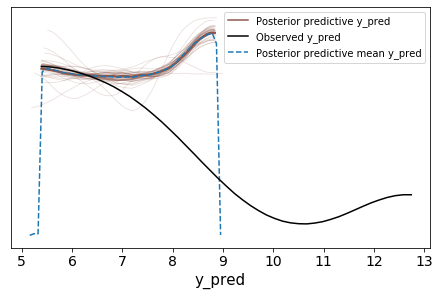

In [38]:
ypred_q12a = pm.sample_posterior_predictive(trace_q12a, 100, model_q12a)
ppc_q12a = az.from_pymc3(trace=trace_q12a, posterior_predictive=ypred_q12a)
az.plot_ppc(ppc_q12a)
_ = plt.legend(loc="best")

In [39]:
with pm.Model() as model_q12b:
    α = pm.Normal('α', mu=y.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν = pm.Exponential('ν', 1/29)
    y_pred = pm.StudentT('y_pred', mu=α + β * x, sd=ϵ, nu=ν, observed=y)
    trace_q12b = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, ϵ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [01:04<00:00, 154.70draws/s]
The acceptance probability does not match the target. It is 0.024444525047025944, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.02437981199578295, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.023588437039044785, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.011597101741351028, but should 

100%|██████████| 100/100 [00:00<00:00, 877.87it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


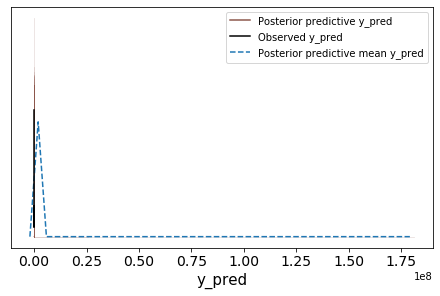

In [40]:
ypred_q12b = pm.sample_posterior_predictive(trace_q12b, 100, model_q12b)
ppc_q12b = az.from_pymc3(trace=trace_q12b, posterior_predictive=ypred_q12b)
az.plot_ppc(ppc_q12b)
_ = plt.legend(loc="best")

In [41]:
with pm.Model() as model_q12c:
    α = pm.Normal('α', mu=y.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν = pm.Gamma('ν', 2, 0.1)
    y_pred = pm.StudentT('y_pred', mu=α + β * x, sd=ϵ, nu=ν, observed=y)
    trace_q12c = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, ϵ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [01:25<00:00, 116.97draws/s]
The acceptance probability does not match the target. It is 0.1601955741631867, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.32408102730149296, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 9.932787969716e-18, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6289540797131594, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parame

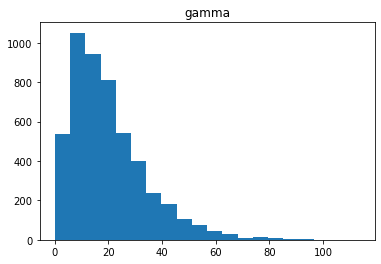

In [42]:
priors = pm.sample_prior_predictive(samples=5000, model=model_q12c)
gamma = priors["ν"]

plt.hist(gamma, bins=20)
plt.title("gamma")
_ = plt.show()

100%|██████████| 100/100 [00:00<00:00, 1000.16it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


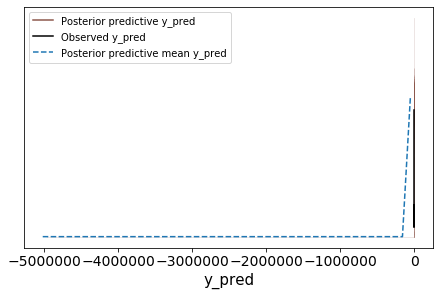

In [43]:
ypred_q12c = pm.sample_posterior_predictive(trace_q12c, 100, model_q12c)
ppc_q12c = az.from_pymc3(trace=trace_q12c, posterior_predictive=ypred_q12c)
az.plot_ppc(ppc_q12c)
_ = plt.legend(loc="best")

## Question 13

For the `unpooled_model`, change the value of sd of the prior; try values of 1 and 100. Explore how the estimated slopes change for each group. Which group is more affected by this change?

<font color="blue">
    <p>The $\beta$7 group, consisting of a single point, is most affected by the change in standard deviation of the prior.</p>
</font>

In [44]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)
alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))
y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real
x_centered = x_m - x_m.mean()

In [45]:
with pm.Model() as model_13a:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=1, shape=M)
    β = pm.Normal('β', mu=0, sd=1, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)
    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
    sd=ϵ, nu=ν, observed=y_m)
    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    trace_13a = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, ϵ, β, α_tmp]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:14<00:00, 694.60draws/s]


In [46]:
az.summary(trace_13a, var_names=["β"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
β[0],0.548,0.825,-0.953,2.145,0.006,0.008,17594.0,4970.0,17552.0,6145.0,1.0
β[1],-0.181,0.901,-1.915,1.490,0.007,0.012,17677.0,3018.0,17734.0,5657.0,1.0
β[2],0.140,0.921,-1.580,1.858,0.007,0.011,18230.0,3740.0,18263.0,6692.0,1.0
β[3],-0.073,0.859,-1.696,1.523,0.007,0.010,17367.0,3469.0,17321.0,5908.0,1.0
β[4],0.415,0.921,-1.409,2.061,0.007,0.010,16543.0,4114.0,16548.0,6194.0,1.0
β[5],0.205,0.880,-1.427,1.923,0.007,0.011,18140.0,3249.0,18167.0,6075.0,1.0
β[6],0.123,0.871,-1.521,1.741,0.007,0.011,17935.0,3039.0,17945.0,6143.0,1.0
β[7],0.003,0.986,-1.775,1.875,0.008,0.012,16215.0,3477.0,16270.0,6380.0,1.0


In [47]:
with pm.Model() as model_13b:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=100, shape=M)
    β = pm.Normal('β', mu=0, sd=100, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)
    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
    sd=ϵ, nu=ν, observed=y_m)
    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    trace_13b = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, ϵ, β, α_tmp]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:20<00:00, 477.29draws/s]


In [48]:
az.summary(trace_13b, var_names=["β"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
β[0],0.895,0.076,0.752,1.035,0.001,0.001,9798.0,9633.0,9814.0,5591.0,1.0
β[1],0.875,0.115,0.656,1.085,0.001,0.001,10913.0,10913.0,10917.0,5597.0,1.0
β[2],0.594,0.126,0.348,0.816,0.001,0.001,10485.0,10380.0,10486.0,5841.0,1.0
β[3],0.700,0.089,0.533,0.867,0.001,0.001,9060.0,9057.0,9078.0,5394.0,1.0
β[4],0.872,0.129,0.627,1.110,0.001,0.001,10712.0,10464.0,10721.0,6032.0,1.0
β[5],0.678,0.103,0.477,0.869,0.001,0.001,10734.0,10660.0,10748.0,5844.0,1.0
β[6],0.984,0.091,0.814,1.154,0.001,0.001,10117.0,10057.0,10137.0,5978.0,1.0
β[7],-0.246,98.473,-176.661,188.756,1.280,1.148,5914.0,3679.0,5919.0,5174.0,1.0


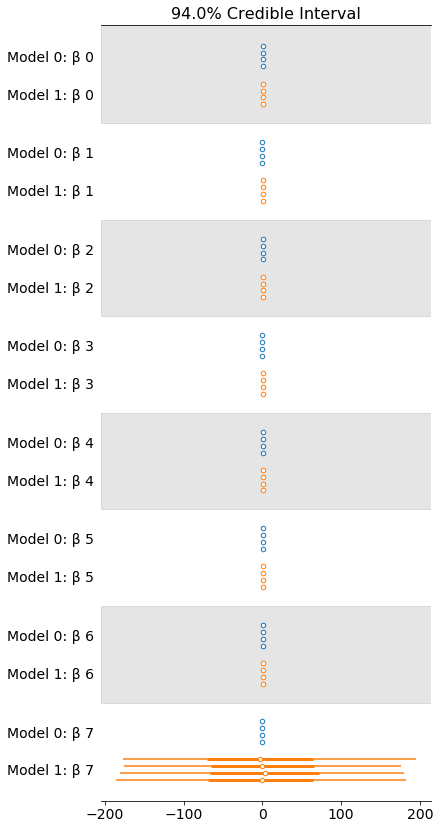

In [49]:
_ = az.plot_forest([trace_13a, trace_13b], var_names=["β"])

## Question 14

Using model `hierarchical_model` repeat Figure 3.17, the one with the eight groups and the eight lines, but this time add the uncertainty of the linear fit.

In [50]:
with pm.Model() as model_14:
    # hyper-priors
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sd=10)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 10)
    β_μ = pm.Normal('β_μ', mu=0, sd=10)
    β_σ = pm.HalfNormal('β_σ', sd=10)
    # priors
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)
    y_pred = pm.StudentT('y_pred', mu = α_tmp[idx] + β[idx] * x_centered, sd=ϵ, nu=ν, observed=y_m)
    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())
    trace_14 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, ϵ, β, α_tmp, β_σ, β_μ, α_σ_tmp, α_μ_tmp]
Sampling 4 chains, 110 divergences: 100%|██████████| 6000/6000 [00:17<00:00, 342.86draws/s]
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [51]:
ppc = pm.sample_posterior_predictive(trace_14, samples=2000, model=model_14)
hpd_y_pred = pm.stats.hpd(ppc["y_pred"])
ppc["y_pred"].shape, hpd_y_pred.shape

100%|██████████| 2000/2000 [00:01<00:00, 1118.13it/s]


((2000, 141), (141, 2))

In [52]:
hpd_y_pred[0], y_m[0]

(array([10.3960452 , 12.18371048]), 11.354397699586432)

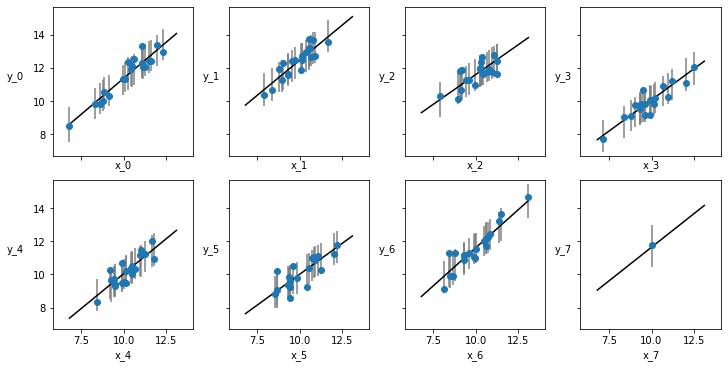

In [53]:
_, ax = plt.subplots(2, 4, figsize=(10, 5), 
                     sharex=True, sharey=True, constrained_layout=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):

#     # points
#     ax[i].scatter(x_m[j:k], y_m[j:k])
    # points + error bars for each point
    y_lowers = y_m[j:k] - hpd_y_pred[j:k, 0]
    y_uppers = hpd_y_pred[j:k, 1] - y_m[j:k]
    yerrs = np.vstack([y_lowers, y_uppers])
    ax[i].errorbar(x_m[j:k], y_m[j:k], yerr=yerrs, fmt="o", ecolor="gray")

    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = trace_14['α'][:, i].mean()
    beta_m = trace_14['β'][:, i].mean()
    
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k', 
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N

## Question 15

Re-run the `model_mlr` example, this time without centering the data. Compare the uncertainty in the parameter for one case and the other. Can you explain these results? 

Tip: Remember the definition of the $\alpha$ parameter (also known as the intercept).

<font color="blue">
<p>Uncertainty of $\beta$ (the coefficients of the multiple linear regression) as given by HPD 3% and HPD 97% are largely similar in both cases (with centering in the book, and without centering here). However, these values for the $\alpha$[0] parameter are different because this represents the combination of the intercept values. Since the variables are not mean centered here, these values are higher.
</font>

In [54]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)
X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2], [1, 1.5])]).T
X_mean = X.mean(axis=0, keepdims=True)
y = alpha_real + np.dot(X, beta_real) + eps_real

In [55]:
X_mean

array([[10.1291923 ,  1.99519902]])

In [56]:
with pm.Model() as model_15:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = α_tmp + pm.math.dot(X, β)
    α = pm.Deterministic('α', α_tmp - pm.math.dot(X_mean, β))
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_15 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α_tmp]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:17<00:00, 562.77draws/s]
The acceptance probability does not match the target. It is 0.8803917267843291, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8922608717250324, but should be close to 0.8. Try to increase the number of tuning steps.


In [57]:
az.summary(trace_15, var_names=['α', 'β', 'ϵ'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α[0],-10.887,0.928,-12.672,-9.192,0.018,0.013,2699.0,2677.0,2696.0,3105.0,1.0
β[0],0.968,0.045,0.883,1.050,0.001,0.001,2744.0,2731.0,2744.0,3033.0,1.0
β[1],1.470,0.033,1.408,1.530,0.000,0.000,5461.0,5461.0,5451.0,4899.0,1.0
ϵ,0.474,0.034,0.412,0.541,0.000,0.000,4763.0,4747.0,4764.0,4407.0,1.0
